#### ViT Model for Classification of All Defects (including nones)
ViT Model from Google [paper](https://arxiv.org/abs/2010.11929)
using Keras implementation from faustomorales [GitHub](https://github.com/faustomorales/vit-keras)

Data preprocessing:
- Resized to 224x224 with no filters
- None is randomly undersampled to 30,000.

ViT model:
- Size = Base (12 layers, D = 768)
- Patch size = 16
- Using included top with softmax activation

In [1]:
#### RUN VIT REQUIREMENTS NOTEBOOK FIRST ####
# need to install required packages to environment before running the model

In [2]:
# import libraries
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import datasets, layers, models, losses, optimizers, regularizers, callbacks
from vit_keras import vit, utils

import os
import time
import numpy as np
import pandas as pd
import cv2
from skimage.morphology import skeletonize, thin

import helpers as helper
from keras_model_s3_wrapper import *

import boto3
import pickle5 as pickle
s3 = boto3.resource('s3')
bucket_name = 'wafer-capstone'
my_bucket = s3.Bucket(bucket_name)

In [3]:
tf.__version__

'2.4.0'

In [4]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

In [5]:
tf.config.list_physical_devices(device_type=None)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]

In [6]:
# specify variables
path = 'processed_data/vit'
filename = 'WM-clean-vit224-undersampled'

result_path = 'results_vit'
model_id = 'vit-b16'
data_id = '224-undersampled'
note = '' # -optional

In [7]:
!free -h

             total       used       free     shared    buffers     cached
Mem:          240G        21G       218G        32M       1.8G        16G
-/+ buffers/cache:       3.8G       236G
Swap:           0B         0B         0B


In [8]:
# load dataset
from io import BytesIO
start = time.time()

data_key = f'{path}/{filename}.npz'
data_obj = my_bucket.Object(data_key).get()['Body'].read()
data = np.load(BytesIO(data_obj), allow_pickle=True)

print('Wall time: {:.3f} seconds'.format(time.time() - start))
data.files

Wall time: 3.652 seconds


['ids', 'labels', 'dataset', 'wafermap']

In [9]:
!free -h

             total       used       free     shared    buffers     cached
Mem:          240G        21G       218G        32M       1.8G        16G
-/+ buffers/cache:       4.0G       236G
Swap:           0B         0B         0B


#### Data set-up

In [10]:
# prepare inputs
start = time.time()

x_train = data['wafermap'][data['dataset']=='train']
x_val = data['wafermap'][data['dataset']=='dev']
x_test = data['wafermap'][data['dataset']=='test']

print('Wall time: {:.3f} seconds'.format(time.time() - start))
print(f'Train: {x_train.shape}')
print(f'Dev: {x_val.shape}')
print(f'Test: {x_test.shape}')

Wall time: 130.430 seconds
Train: (47863, 224, 224, 3)
Dev: (25942, 224, 224, 3)
Test: (25943, 224, 224, 3)


In [11]:
# prepare labels for supervised learning
# note: make sure labels are integers if using sparse categorical cross entropy
start = time.time()

y_train = data['labels'][data['dataset']=='train']
y_val = data['labels'][data['dataset']=='dev']
y_test = data['labels'][data['dataset']=='test']

print("Wall time: {:.2f} seconds".format(time.time() - start))
# sanity check
# expected: type = int, min = 0, max = 8
print(type(y_train[0]))
print(min(y_train), min(y_val), min(y_test))
print(max(y_train), max(y_val), max(y_test))

Wall time: 0.03 seconds
<class 'numpy.uint8'>
0 0 0
8 8 8


In [12]:
!free -h

             total       used       free     shared    buffers     cached
Mem:          240G        36G       204G        32M       1.8G        16G
-/+ buffers/cache:        18G       221G
Swap:           0B         0B         0B


#### Model

In [13]:
# fine-tune using pre-trained vit model
image_size = 224
model = vit.vit_b16(
    image_size=image_size,
    activation='softmax',
    pretrained=True,
    include_top=True,
    pretrained_top=False,
    classes=9
)

model.summary()

347504640/347502902 [==============================] - 11s 0us/step


/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/vit_keras/utils.py:83: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  UserWarning,


Model: "vit-b16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
embedding (Conv2D)           (None, 14, 14, 768)       590592    
_________________________________________________________________
reshape (Reshape)            (None, 196, 768)          0         
_________________________________________________________________
class_token (ClassToken)     (None, 197, 768)          768       
_________________________________________________________________
Transformer/posembed_input ( (None, 197, 768)          151296    
_________________________________________________________________
Transformer/encoderblock_0 ( ((None, 197, 768), (None, 7087872   
_________________________________________________________________
Transformer/encoderblock_1 ( ((None, 197, 768), (None, 7087

In [14]:
# set model optimizer and metrics
opt = optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer='adam', loss=losses.sparse_categorical_crossentropy, metrics=['accuracy'])

In [15]:
!free -h

             total       used       free     shared    buffers     cached
Mem:          240G        36G       203G        32M       1.8G        16G
-/+ buffers/cache:        18G       221G
Swap:           0B         0B         0B


In [16]:
# run model
start = time.time()

history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=32, epochs=10)

print("Wall time: {:.2f} seconds".format(time.time() - start))

Epoch 1/10
1496/1496 [==============================] - 750s 489ms/step - loss: 0.9047 - accuracy: 0.7500 - val_loss: 0.5498 - val_accuracy: 0.8536
Epoch 2/10
1496/1496 [==============================] - 726s 486ms/step - loss: 0.5463 - accuracy: 0.8283 - val_loss: 0.2550 - val_accuracy: 0.9298
Epoch 3/10
1496/1496 [==============================] - 727s 486ms/step - loss: 0.5130 - accuracy: 0.8391 - val_loss: 0.2337 - val_accuracy: 0.9334
Epoch 4/10
1496/1496 [==============================] - 727s 486ms/step - loss: 0.4814 - accuracy: 0.8472 - val_loss: 0.2141 - val_accuracy: 0.9361
Epoch 5/10
1496/1496 [==============================] - 727s 486ms/step - loss: 0.4644 - accuracy: 0.8515 - val_loss: 0.2535 - val_accuracy: 0.9317
Epoch 6/10
1496/1496 [==============================] - 726s 486ms/step - loss: 0.4499 - accuracy: 0.8553 - val_loss: 0.3593 - val_accuracy: 0.8918
Epoch 7/10
1496/1496 [==============================] - 725s 485ms/step - loss: 0.4325 - accuracy: 0.8624 - val_

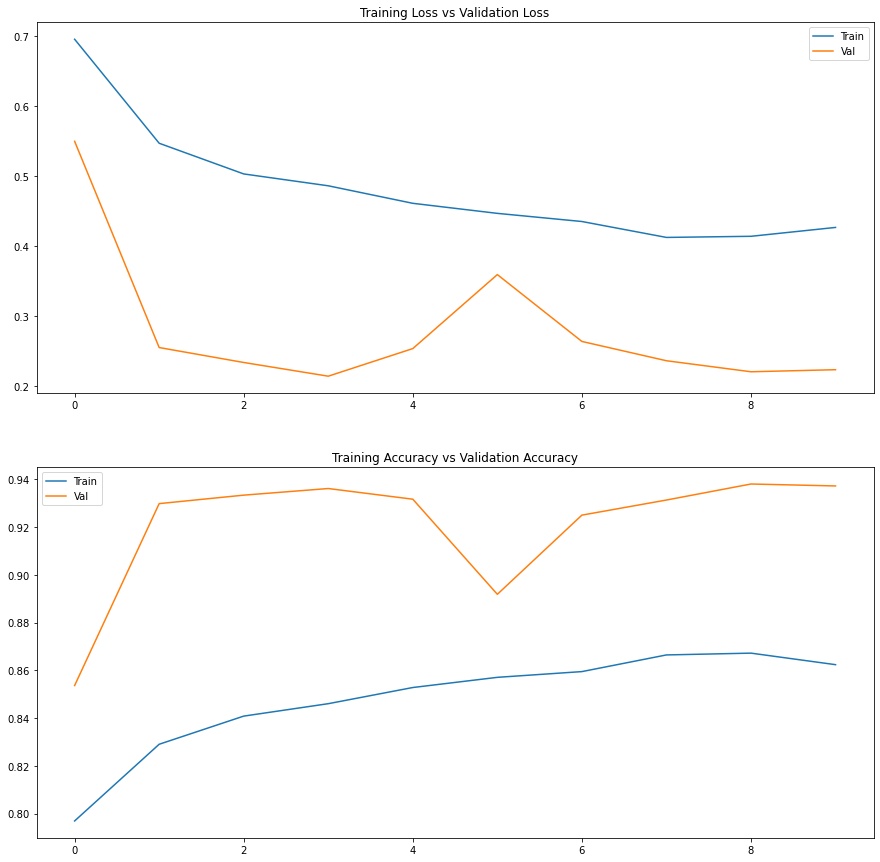

In [17]:
# visualize accuracy and loss history
fig, axs = plt.subplots(2, 1, figsize=(15,15))

axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].legend(['Train', 'Val'])

axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].legend(['Train', 'Val'])

#### Model results

In [24]:
# save model to S3
# s3_save_keras_model(model, f'{model_id}-{data_id}{note}')
model.save(f'{model_id}-{data_id}{note}.h5')

In [19]:
# compute model results on test set
start = time.time()
results = model.evaluate(x_test, y_test)
print("Wall time: {:.2f} seconds".format(time.time() - start))
print(results)

811/811 [==============================] - 115s 141ms/step - loss: 0.2202 - accuracy: 0.9403
Wall time: 117.44 seconds
[0.22024674713611603, 0.9403307437896729]


In [20]:
# generate predictions for model analysis
start = time.time()
y_pred = model.predict(x_test)
y_max = np.argmax(y_pred, axis=1).astype(np.uint8)
predictions = [y_max, y_pred]
print("Wall time: {:.2f} seconds".format(time.time() - start))

Wall time: 118.45 seconds


In [21]:
# save predictions to local instance
with open(f'{result_path}/{model_id}-{data_id}{note}.pkl', "wb") as f:
    pickle.dump(predictions, f)

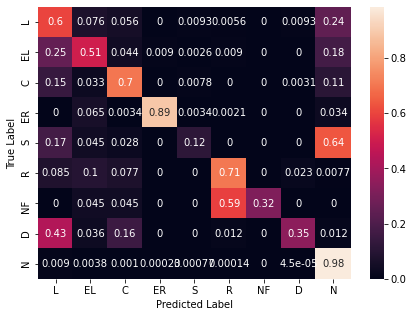

In [22]:
# plot confusion matrix
helper.plot_confusion_matrix(y_test, y_max, mode='all', normalize=True)

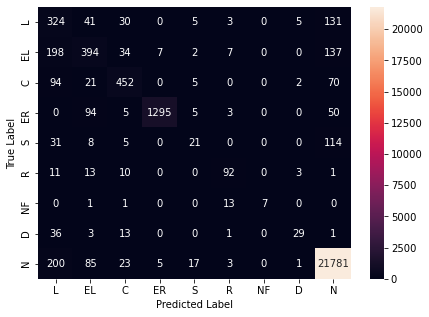

In [23]:
# plot confusion matrix counts
helper.plot_confusion_matrix(y_test, y_max, mode='all', normalize=False)